In [473]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#!/usr/bin/env python3
from bs4 import BeautifulSoup
import re

# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [474]:
df = pd.read_csv('scrapped_data.csv')
df.tail()

,question_id,title,content,difficulty,likes,dislikes,similar_questions,topic_tags,stats,hints
2004,5,Longest Palindromic Substring,"<p>Given a string <code>s</code>, return <em>t...",Medium,16824,984,"[{""title"": ""Shortest Palindrome"", ""titleSlug"":...","[{'name': 'String', 'slug': 'string', 'transla...","{""totalAccepted"": ""1.8M"", ""totalSubmission"": ""...",['How can we reuse a previously computed palin...
2005,4,Median of Two Sorted Arrays,<p>Given two sorted arrays <code>nums1</code> ...,Hard,15727,1942,[],"[{'name': 'Array', 'slug': 'array', 'translate...","{""totalAccepted"": ""1.3M"", ""totalSubmission"": ""...",[]
2006,3,Longest Substring Without Repeating Characters,"<p>Given a string <code>s</code>, find the len...",Medium,22547,1011,"[{""title"": ""Longest Substring with At Most Two...","[{'name': 'Hash Table', 'slug': 'hash-table', ...","{""totalAccepted"": ""3.1M"", ""totalSubmission"": ""...",[]
2007,2,Add Two Numbers,<p>You are given two <strong>non-empty</strong...,Medium,17566,3648,"[{""title"": ""Multiply Strings"", ""titleSlug"": ""m...","[{'name': 'Linked List', 'slug': 'linked-list'...","{""totalAccepted"": ""2.7M"", ""totalSubmission"": ""...",[]
2008,1,Two Sum,<p>Given an array of integers <code>nums</code...,Easy,30718,967,"[{""title"": ""3Sum"", ""titleSlug"": ""3sum"", ""diffi...","[{'name': 'Array', 'slug': 'array', 'translate...","{""totalAccepted"": ""6.3M"", ""totalSubmission"": ""...","[""A really brute force way would be to search ..."


In [475]:
df.shape

(2009, 10)

In [476]:
#count of null values in each column
df.isnull().sum()

question_id            0
title                  0
content              309
difficulty             0
likes                  0
dislikes               0
similar_questions      0
topic_tags             0
stats                  0
hints                  0
dtype: int64

In [477]:
#check for duplicate questions in the dataset
# observation- no duplicates as the number of the rows in the dataset is equal to number of unique questions ids
df['question_id'].nunique()

2009

Medium    1095
Easy       467
Hard       447
Name: difficulty, dtype: int64


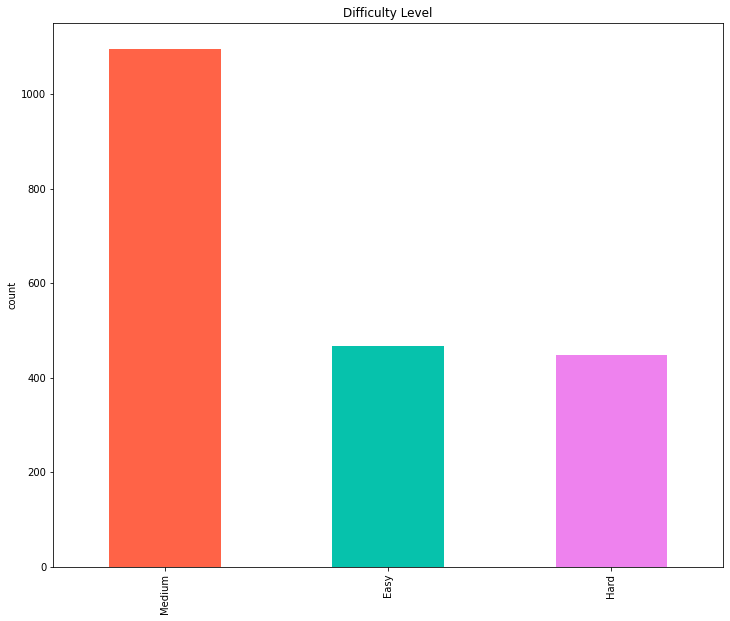

In [478]:
#count of questions based on difficult level
x = df['difficulty'].value_counts()
print(x)
colors = ['#FF6347', '#06C2AC','#EE82EE']
fig_dims = (12, 10)
fig, ax = plt.subplots(figsize=fig_dims)
x.plot(kind = 'bar',
       title = 'Difficulty Level',
       ylabel='count',
       color = colors,
       ax=ax)
plt.show()

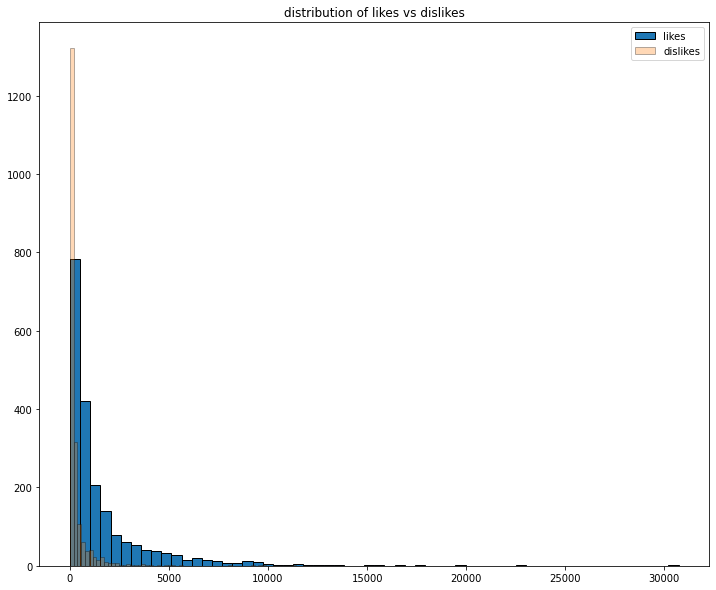

In [479]:
#Observation - Both the distributions are highly skewed

#likes
x = df['likes']
#dislikes
y = df['dislikes']

fig_dims = (12, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.hist(x, bins= 60, label='likes',  edgecolor = 'black')
plt.hist(y, bins=60, alpha=0.3, label='dislikes',  edgecolor = 'black')
plt.legend()
plt.title('distribution of likes vs dislikes')
plt.show()

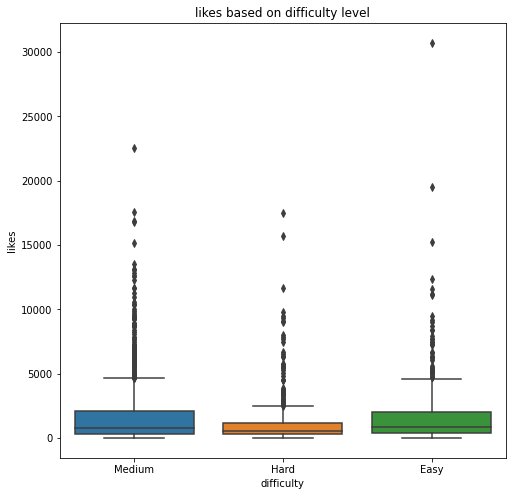

In [480]:
#likes and dislikes based on difficulty level
y = df['likes']
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('likes based on difficulty level')
sns.boxplot(x = x, y = y, ax=ax)
plt.show()

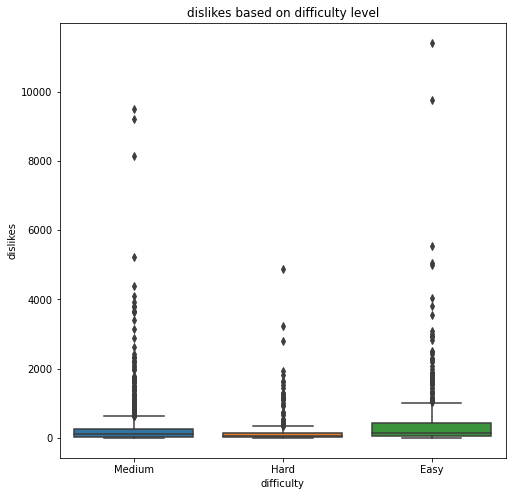

In [481]:
#likes and dislikes based on difficulty level
y = df['dislikes']
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('dislikes based on difficulty level')
sns.boxplot(x = x, y = y, ax=ax)
plt.show()

In [482]:
#stats consist of multiple values 
df['stats'][1]

'{"totalAccepted": "562", "totalSubmission": "870", "totalAcceptedRaw": 562, "totalSubmissionRaw": 870, "acRate": "64.6%"}'

In [483]:
#changing stats into 4 seperate columns(each key as a seperate column)

#changing dtype of stats column from str to dict
import ast
for i in range(len(df)):
    # using ast.literal_eval() method
    df['stats'][i] = ast.literal_eval(df['stats'][i])

#changing each key of dictionary to a column in the dataframe
df = pd.concat([df, df["stats"].apply(pd.Series)], axis=1)
df.drop('stats',axis=1,inplace=True)

In [484]:
#replacing K(thousand) & M(million)  with their respective numeric values and changing dtypes to numeric
df["totalAccepted"] = df["totalAccepted"].replace({"K":"*1e3", "M":"*1e6"}, regex=True).map(pd.eval).astype(int)
df["totalSubmission"] = df["totalSubmission"].replace({"K":"*1e3", "M":"*1e6"}, regex=True).map(pd.eval).astype(int)

In [485]:
#checking for data error
#check if number of accepted sol > no of submitted solution
df[df['totalAccepted']>df['totalSubmission']]  #turned out to be null

,question_id,title,content,difficulty,likes,dislikes,similar_questions,topic_tags,hints,totalAccepted,totalSubmission,totalAcceptedRaw,totalSubmissionRaw,acRate


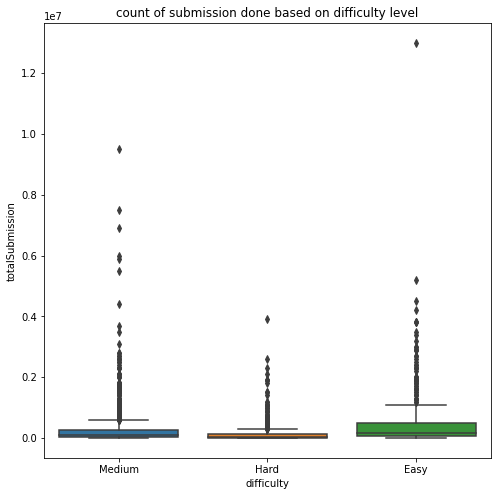

In [486]:
#count of submission are comparatively lower for hard questions
#count of submission done based on difficulty level
y = df['totalSubmission']
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('count of submission done based on difficulty level')
sns.boxplot(x = x, y = y, ax=ax)
plt.show()

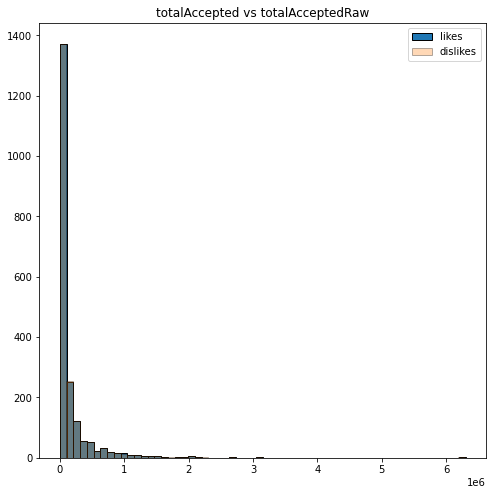

In [487]:
#distribution plots of totalAccepted and totalAcceptedRaw
x = df['totalAccepted']
y = df['totalAcceptedRaw']

fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.hist(x, bins= 60, label='likes',  edgecolor = 'black')
plt.hist(y, bins=60, alpha=0.3, label='dislikes',  edgecolor = 'black')
plt.legend()
plt.title('totalAccepted vs totalAcceptedRaw')
plt.show()

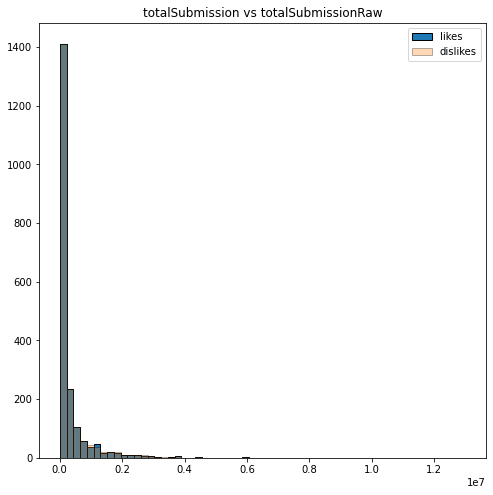

In [488]:
#distribution plots of totalSubmission and totalSubmissionRaw
x = df['totalSubmission']
y = df['totalSubmissionRaw']

fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.hist(x, bins= 60, label='likes',  edgecolor = 'black')
plt.hist(y, bins=60, alpha=0.3, label='dislikes',  edgecolor = 'black')
plt.legend()
plt.title('totalSubmission vs totalSubmissionRaw')
plt.show()

In [489]:
# Observation - since the distribution of both the features is exactly same we can drop any two of them as they are redundant
#droppping totalAcceptedRaw and totalSubmissionRaw
df.drop(['totalAcceptedRaw', 'totalSubmissionRaw'], axis=1, inplace=True)

In [490]:
##replacing % with empty character and change dtype to float
#ac rate is the success rate that is total accepted solution to total submissions made
df['acRate'] = df['acRate'].str.replace('%', '')
df['acRate'] = df['acRate'].astype('float')

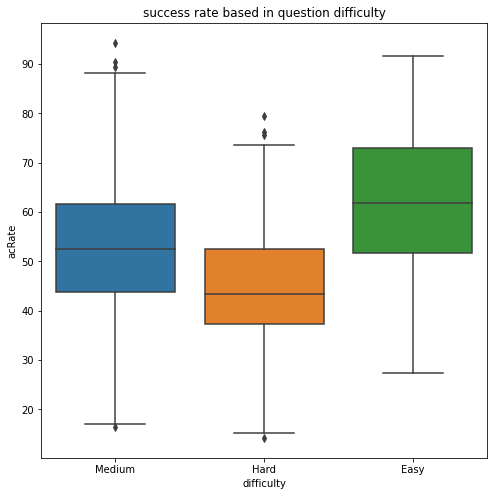

In [491]:
#observation - easy questions have a compartitvely higher acRate then other questions()
#acRate based in question difficulty
y = df['acRate']
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('success rate based in question difficulty')
sns.boxplot(x = x, y = y, ax=ax)
plt.show()

# Topic Tags

In [492]:
#converting the data into list of unique tags assoicated with each question
tags_lst=[] 
#iterating over every element of df
for i in range(len(df)):
    #change topic_tags to list of dict
    df['topic_tags'][i] =eval(df['topic_tags'][i])
    tag = []
    #check list length
    if len(df['topic_tags'][i])<1:
        tag.append('')
    else:
        #iterate over len of list
        for j in range(len(df['topic_tags'][i])):
            #extract value corresponding to the name key(tag)
            tag.append(df['topic_tags'][i][j]['name'])
    #append the list of tags into a single list
    tags_lst.append(tag)
df['topic_tags'] = tags_lst

In [493]:
#convert list of tags to string of tags
for i in range(len(df['topic_tags'])):
    tag_str = ' '.join(df['topic_tags'][i])
    df['topic_tags'][i]  = tag_str

In [494]:
#number of unique tags in the data
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(df['topic_tags'])
print("Number of unique tags :", tag_dtm.shape[1])

Number of unique tags : 89


[]

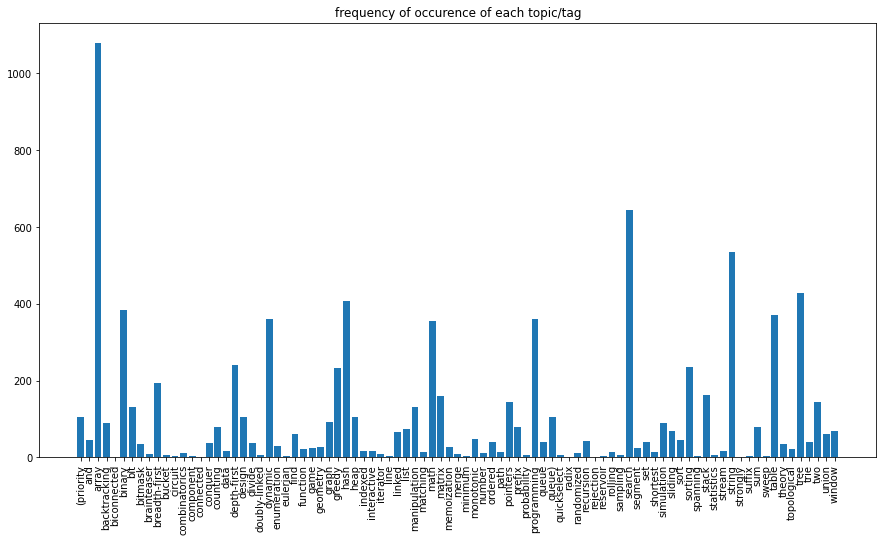

In [495]:
#frequency of occurence of each topics/tags
tags = vectorizer.get_feature_names()
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.bar(range(len(result)), list(result.values()), align='center')
plt.xticks(range(len(result)), list(result.keys()), rotation = 90)
plt.title('frequency of occurence of each topic/tag')
plt.plot()

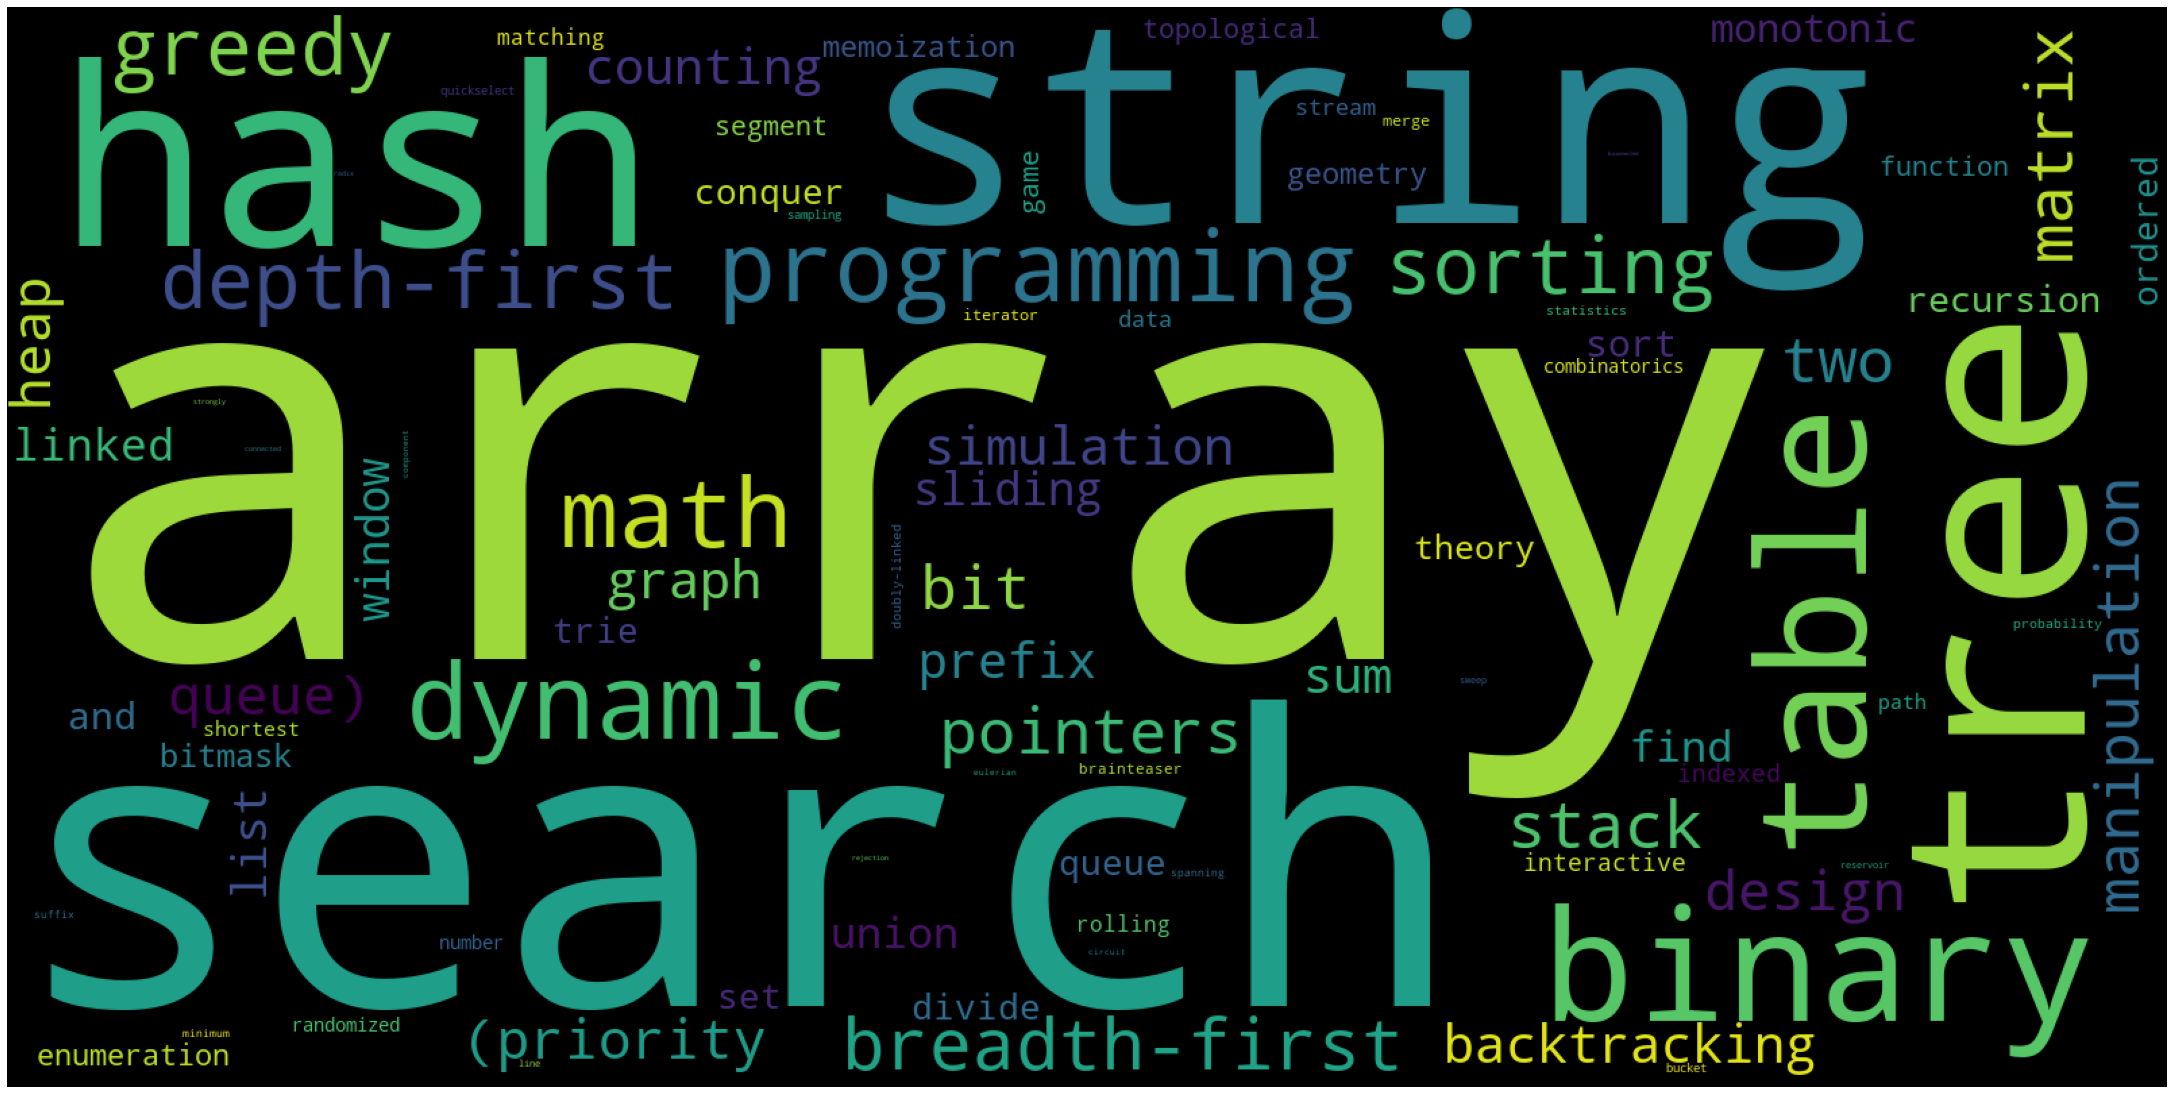

Time taken to run this cell : 0:00:02.612671


In [496]:
#Observation- arrays, searching, binary tree, string are some of the most frequently occuring tags 
from datetime import datetime
from wordcloud import WordCloud
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

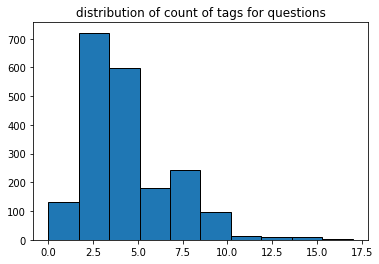

In [497]:
#seems a good distribution 
#count of tags associated with each question
lst = [len(i.split()) for i in df['topic_tags']]
plt.hist(lst, edgecolor = 'black')
plt.title('distribution of count of tags for questions')
plt.show()

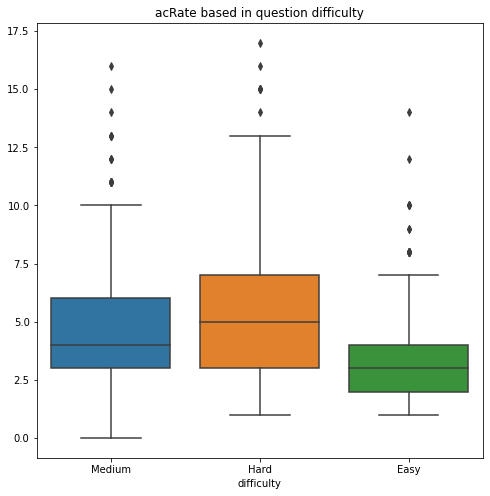

In [498]:
#count of tags based on difficulty level
# observation -  hard and medium questions have more tags attached as they are multiconceptual questions
lst = [len(i.split()) for i in df['topic_tags']]
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('acRate based in question difficulty')
sns.boxplot(x = x, y = lst, ax=ax)
plt.show()

# Titles

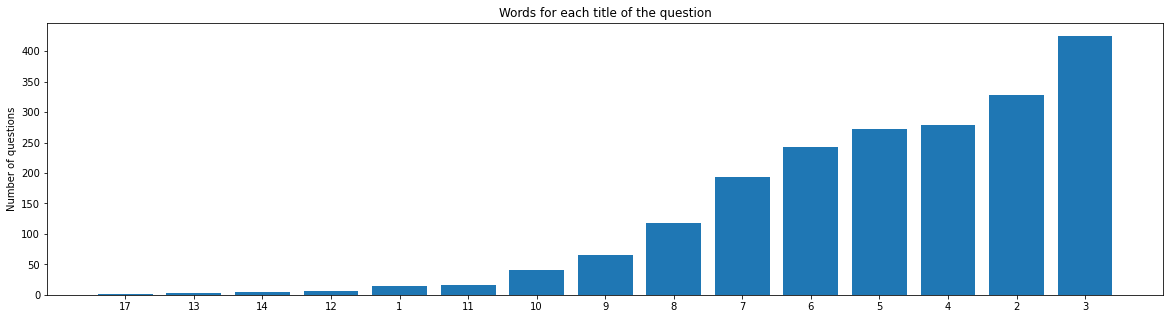

In [499]:
# observation - can be a good feature as we can see some distribution in length of title(the distribution is not very skewed)
#DataFrame: https://stackoverflow.com/a/37483537/4084039
#number of words in title of a question
word_count = df['title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of questions')
plt.title('Words for each title of the question')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [500]:
#not much processing of text is required as most of the text looks clean
#lower case
#remove some punctuation
#printing some question titles randomly
import random
samples = random.sample(range(0, 2000), 100)
for i in samples:
    print(df['title'][i])

Minimum Path Sum
My Calendar I
Valid Parentheses
Get Biggest Three Rhombus Sums in a Grid
Vertical Order Traversal of a Binary Tree
Divide Array Into Increasing Sequences
Maximum Absolute Sum of Any Subarray
Maximum Score From Removing Substrings
Verbal Arithmetic Puzzle
Amount of New Area Painted Each Day
Unique Substrings in Wraparound String
Digit Count in Range
Handshakes That Don't Cross
Minimum Falling Path Sum
Design Linked List
Online Majority Element In Subarray
Maximum Matrix Sum
Palindrome Pairs
Minimum Operations to Reduce X to Zero
Closest Leaf in a Binary Tree
Integer Break
Count Triplets That Can Form Two Arrays of Equal XOR
Pseudo-Palindromic Paths in a Binary Tree
Two Best Non-Overlapping Events
Number of Equal Count Substrings
Sum of All Odd Length Subarrays
X of a Kind in a Deck of Cards
Video Stitching
Reorganize String
Maximum Equal Frequency
Find Unique Binary String
Shortest Path with Alternating Colors
Coin Change 2
Distinct Subsequences II
Maximum Sum Score of 

# Content

In [501]:
#cleaning is required as the data contains many html tags and unnecessary information which can be removed.
#I will only keep the question text and remove the sample cases/exmaple/explanation in the data
df['content'][6]

'<p>Alice and Bob are opponents in an archery competition. The competition has set the following rules:</p>\n\n<ol>\n\t<li>Alice first shoots <code>numArrows</code> arrows and then Bob shoots <code>numArrows</code> arrows.</li>\n\t<li>The points are then calculated as follows:\n\t<ol>\n\t\t<li>The target has integer scoring sections ranging from <code>0</code> to <code>11</code> <strong>inclusive</strong>.</li>\n\t\t<li>For <strong>each</strong> section of the target with score <code>k</code> (in between <code>0</code> to <code>11</code>), say Alice and Bob have shot <code>a<sub>k</sub></code> and <code>b<sub>k</sub></code> arrows on that section respectively. If <code>a<sub>k</sub> &gt;= b<sub>k</sub></code>, then Alice takes <code>k</code> points. If <code>a<sub>k</sub> &lt; b<sub>k</sub></code>, then Bob takes <code>k</code> points.</li>\n\t\t<li>However, if <code>a<sub>k</sub> == b<sub>k</sub> == 0</code>, then <strong>nobody</strong> takes <code>k</code> points.</li>\n\t</ol>\n\t<

In [502]:
#content consist of problem statement along with examples and constraints.
#I will only filter the problem statement and remove the examples and constraints.
#  text = '''
# <td><a href="http://www.irit.fr/SC">Signal et Communication</a>
# <br/><a href="http://www.irit.fr/IRT">Ingénierie Réseaux et Télécommunications</a>
# </td>
# '''
#actual quetion after removing tags
v = df['content'][6]
soup = BeautifulSoup(v)

print(soup.get_text())

Alice and Bob are opponents in an archery competition. The competition has set the following rules:

Alice first shoots numArrows arrows and then Bob shoots numArrows arrows.
The points are then calculated as follows:
	
The target has integer scoring sections ranging from 0 to 11 inclusive.
For each section of the target with score k (in between 0 to 11), say Alice and Bob have shot ak and bk arrows on that section respectively. If ak >= bk, then Alice takes k points. If ak < bk, then Bob takes k points.
However, if ak == bk == 0, then nobody takes k points.





For example, if Alice and Bob both shot 2 arrows on the section with score 11, then Alice takes 11 points. On the other hand, if Alice shot 0 arrows on the section with score 11 and Bob shot 2 arrows on that same section, then Bob takes 11 points.


You are given the integer numArrows and an integer array aliceArrows of size 12, which represents the number of arrows Alice shot on each scoring section from 0 to 11. Now, Bob wan

In [503]:
#replace all the null value in content with its corresponding title
df['content'].fillna(df['title'], inplace=True)

# Similar Questions

In [504]:
import json
lst = []
for i in range(len(df)):
    #iterate over each row of dataframe
    df['similar_questions'][i]  = df['similar_questions'][i].replace("'", "")
    #convert it into a list of dict
    df['similar_questions'][i] = json.loads(df['similar_questions'][i])
    lst_title = []
    #iterate over every list of dict
    for j in range(len(df['similar_questions'][i])):
        #extract the titles of similar questions for each question
        title = df['similar_questions'][i][j]['title']
        #store the titles in a list
        lst_title.append(title)
    #append all the list of titles into a single list
    lst.append(lst_title)
#replace value in the original dataframe    
df['similar_questions'] = lst

# Hints

In [505]:
df['hints'][0]

"['How can we use precalculation to efficiently calculate the average difference at an index?', 'Create a prefix and/or suffix sum array.']"

In [506]:
for i in range(len(df)):
    #iterate over each row of dataframe convert string representation of list to a list
    df['hints'][i]  = df['hints'][i].replace("'", "")
    #concatenate all the hints
    df['hints'][i]  = ''.join(df['hints'][i])
    #convert concatenated list into string
    df['hints'][i] = df['hints'][i][1:-1]

In [507]:
#there are certain values in hints which are empty lists
df['hints'][2007]

''

In [508]:
#replacing all the empty strings with corresponding title value
for i in range(len(df)):
    if df['hints'][i]=='':
        df['hints'][i] = df['title'][i]

# Data Cleaning & Preprocessing

# Titles

In [509]:
#data consist of roman numerals
for i in df['title']:
    if 'Jump Game' in i:
        print(i)

Jump Game VII
Jump Game VI
Jump Game V
Jump Game IV
Jump Game III
Jump Game
Jump Game II


In [510]:
#dict mapping of roman numerals to words
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
val_map={"I": "One", "II": "Two", "III": "Three", 
         "IV": "Four", "V": "Five", "VI": "Six", "VII": "Seven",
          "VIII": "Eight", "IX": "Nine", "X": "Ten"}
#some commonly found stopwords in the titles
stopwords = ['the', 'in', 'of', 'be', 'so', 'a', 'on', 'by', 'can', 'to', 'an', 'as', 'out', 'is', 'are']
preprocessed_title = []
for title in df['title']:
    #map roman numerical to its corresponding word value
    title = ' '.join([val_map.get(i, i) for i in title.split()])
    #lowercase the text
    title = title.lower()
    #remove stop words
    title = ' '.join([stemmer.stem(word) for word in title.split() if word not in stopwords])
    preprocessed_title.append(title)
df['title'] = preprocessed_title

# Content

In [511]:
df['content'][5]

'<p>You are given a <strong>0-indexed</strong> string <code>s</code>. You are also given a <strong>0-indexed</strong> string <code>queryCharacters</code> of length <code>k</code> and a <strong>0-indexed</strong> array of integer <strong>indices</strong> <code>queryIndices</code> of length <code>k</code>, both of which are used to describe <code>k</code> queries.</p>\n\n<p>The <code>i<sup>th</sup></code> query updates the character in <code>s</code> at index <code>queryIndices[i]</code> to the character <code>queryCharacters[i]</code>.</p>\n\n<p>Return <em>an array</em> <code>lengths</code> <em>of length </em><code>k</code><em> where</em> <code>lengths[i]</code> <em>is the <strong>length</strong> of the <strong>longest substring</strong> of </em><code>s</code><em> consisting of <strong>only one repeating</strong> character <strong>after</strong> the</em> <code>i<sup>th</sup></code> <em>query</em><em> is performed.</em></p>\n\n<p>&nbsp;</p>\n<p><strong>Example 1:</strong></p>\n\n<pre>\n<

In [512]:
#content has a lot of html tags
#removing html tags

# https://gist.github.com/sebleier/554280
# punc =  ['!', '()', '-', '[]', '{}', ';', ':','.','?', '@', '#', '$', '%', '^', '&', '*', '_', '~']
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'you',\
            'your', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'also', \
            ]
stemmer = SnowballStemmer("english")

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(text_data):
        #removing the html tags
        soup = BeautifulSoup(sentence)
        sent = soup.get_text()
        #keep the question and remove the examples and explanation
        sent = sent.split('Example 1')[0]
        #removing escape sequences
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        #keep only the alpha numericals
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
#        content = ' '.join([word for word in content.split() if word not in punc])
        #remove stop words
        sent = ' '.join(stemmer.stem(e) for e in sent.split() if e.lower() not in stopwords and len(e)!=1)
        #change to lowercase
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text 

preprocessed_content = preprocess_text(df['content'].values)
df['content'] = preprocessed_content

100%|█████████████████████████████████████████████████████████████████████████████| 2009/2009 [00:04<00:00, 476.26it/s]


# Hints

In [513]:
#hints
preprocessed_hints = preprocess_text(df['hints'])
df['hints'] = preprocessed_hints


100%|████████████████████████████████████████████████████████████████████████████| 2009/2009 [00:01<00:00, 1992.02it/s]


In [514]:
df.isnull().sum()

question_id          0
title                0
content              0
difficulty           0
likes                0
dislikes             0
similar_questions    0
topic_tags           0
hints                0
totalAccepted        0
totalSubmission      0
acRate               0
dtype: int64

In [515]:
df.head()

,question_id,title,content,difficulty,likes,dislikes,similar_questions,topic_tags,hints,totalAccepted,totalSubmission,acRate
0,2369,maximum sum score array,maximum sum score array,Medium,3,3,"[Subarray Sum Equals K, Find Pivot Index, Find...",,can use precalcul effici calcul averag differ ...,121,180,67.2
1,2354,minimum health beat game,minimum health beat game,Medium,18,5,"[Dungeon Game, Eliminate Maximum Number of Mon...",Array Greedy Prefix Sum,should use armor abil alway optim use armor ab...,562,870,64.6
2,2322,number way build sturdi brick wall,number way build sturdi brick wall,Medium,35,12,"[Brick Wall, Bricks Falling When Hit]",Array Dynamic Programming Bit Manipulation Bit...,row brick can repres uniqu point two brick joi...,704,1200,59.0
3,2321,minimum weight subgraph with requir path,given integ denot number node weight direct gr...,Hard,349,11,[Minimum Cost to Make at Least One Valid Path ...,Graph Shortest Path,consid path src1 dest src2 dest would look lik...,5500,15700,34.9
4,2320,find all k-distant indic array,given index integ array num two integ key dist...,Easy,157,25,"[Two Sum, Shortest Word Distance]",Array,everi occurr key num find indic within distanc...,19900,30800,64.5


In [516]:
#topic tag has an empty string
#I replaced it by the array as it was present in the title of the question
df['topic_tags'][0] = 'Array'

In [518]:
df.to_csv('cleaned_dataset.csv', index=False)

In [520]:
s= [0]*10

In [521]:
s

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]